In [ ]:
import pandas as pd
import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
import matplotlib.pyplot as plt

In [ ]:
BB_dict = {'CH2':0, 'NH':1, 'CO':2, 'C6H4':3, 'C4H2S':4,'CS':5,'O':6}
BUILDING_BLOCKS = ['CH2', 'NH', 'CO', 'C6H4', 'C4H2S','CS','O']
df = pd.read_csv('PolymerDFTData.csv')

NUM_SAMPLES = len(df['4-BLOCK POLYMER'])
TRAIN_SIZE = int(0.9 * NUM_SAMPLES)
TEST_SIZE = NUM_SAMPLES - TRAIN_SIZE

print(TRAIN_SIZE, TEST_SIZE)


255 29


In [ ]:
def finger_print_III(data):
    
    polymer_list = list(data.split('-'))
    
#     print(polymer_list)
    
    fingerprintIII_polymer = [[[0 for _ in range(len(BUILDING_BLOCKS))] for _ in range(len(BUILDING_BLOCKS))] for _ in range(len(BUILDING_BLOCKS))]
    
    for i in range(0,len(polymer_list)-2):
        
        polymer1 = polymer_list[i]
#         print(polymer1, BB_dict[polymer1])
        polymer2 = polymer_list[i+1]
    
        polymer3 = polymer_list[i+2]
    
#         print(polymer2, BB_dict[polymer2])
        
        fingerprintIII_polymer[BB_dict[polymer1]][BB_dict[polymer2]][BB_dict[polymer3]] +=1
        
    return fingerprintIII_polymer 


def create_X_data(data):
    """Create the one hot encoding for whole polymer data"""

    all_polymer_encoded = [finger_print_III(polymer) for polymer in data['4-BLOCK POLYMER']]

    X_array = np.array(all_polymer_encoded)/len(BUILDING_BLOCKS)

    return X_array

def create_Y_array(data):
    """Create the Y array from the data"""

    Y_bandgap = data['HSE Band Gap (eV)'].to_numpy()

    Y_bandgap = np.reshape(Y_bandgap,(Y_bandgap.shape[0],1))
    
#     Y_bandgap = (Y_bandgap - np.amin(Y_bandgap))/(np.amax(Y_bandgap) - np.amin(Y_bandgap))

    Y_elec_dielec_const = data['Electronic Dielectric Constant'].to_numpy()

    Y_elec_dielec_const = np.reshape(Y_elec_dielec_const, (Y_elec_dielec_const.shape[0],1))
    
#     Y_elec_dielec_const =(Y_elec_dielec_const - np.amin(Y_elec_dielec_const))/(np.amax(Y_elec_dielec_const) - np.amin(Y_elec_dielec_const))


    Y_ionic_dielec_const = data['Ionic Dielectric Constant'].to_numpy()

    Y_ionic_dielec_const = np.reshape(Y_ionic_dielec_const, (Y_ionic_dielec_const.shape[0], 1))
    
#     Y_ionic_dielec_const =( Y_ionic_dielec_const - np.amin( Y_ionic_dielec_const))/(np.amax( Y_ionic_dielec_const) - np.amin(Y_ionic_dielec_const))



    return Y_elec_dielec_const, Y_ionic_dielec_const, Y_bandgap


In [ ]:
X_polymer_encoded = create_X_data(df)

Y_elec_dielec_const, Y_ionic_dielec_const,  Y_bandgap = create_Y_array(df)

X_train, X_test,Y_elec_train,Y_elec_test,Y_ionic_train,Y_ionic_test,Y_bandgap_train,Y_bandgap_test = train_test_split(X_polymer_encoded,Y_elec_dielec_const, Y_ionic_dielec_const, Y_bandgap, test_size=0.1, shuffle=True)

X_train = X_train.reshape(-1,7*7*7)
X_train.shape


X_test = X_test.reshape(-1,7*7*7)
X_test.shape

(29, 343)

In [ ]:

kr = GridSearchCV(
    KernelRidge(kernel="rbf"),
    param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)})

In [ ]:
kr.fit(X_train,Y_bandgap_train)

GridSearchCV(estimator=KernelRidge(kernel='rbf'),
             param_grid={'alpha': [1.0, 0.1, 0.01, 0.001],
                         'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])})

In [ ]:
Y_bandgap_predicted_test = kr.predict(X_test)
Y_bandgap_predicted_train = kr.predict(X_train)


Text(0, 0.5, 'KRR predictions')

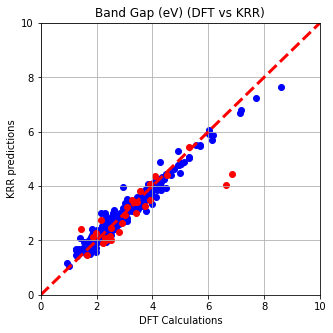

In [ ]:
plt.figure(figsize=(5,5))

plt.scatter(Y_bandgap_train, Y_bandgap_predicted_train,color='blue')
plt.scatter(Y_bandgap_test,Y_bandgap_predicted_test,color='red' )
xpoints = plt.xlim([0,10])
ypoints = plt.ylim([0,10])
plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=3, scalex=False, scaley=False)
plt.title('Band Gap (eV) (DFT vs KRR)')
plt.grid()
plt.xlabel('DFT Calculations')
plt.ylabel('KRR predictions')

In [ ]:
kr.fit(X_train,Y_elec_train)
Y_elec_predicted_test = kr.predict(X_test)
Y_elec_predicted_train = kr.predict(X_train)

Text(0, 0.5, 'KRR predictions')

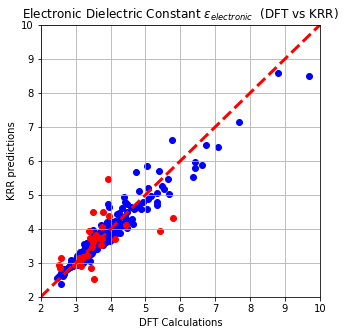

In [ ]:
plt.figure(figsize=(5,5))

plt.scatter(Y_elec_train, Y_elec_predicted_train,color='blue')
plt.scatter(Y_elec_test,Y_elec_predicted_test,color='red' )
xpoints = plt.xlim([2,10])
ypoints = plt.ylim([2,10])
plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=3, scalex=False, scaley=False)
plt.title(r'Electronic Dielectric Constant $\epsilon_{electronic}$  (DFT vs KRR)')
plt.grid()
plt.xlabel('DFT Calculations')
plt.ylabel('KRR predictions')

In [ ]:
kr.fit(X_train,Y_ionic_train)
Y_ionic_predicted_test = kr.predict(X_test)
Y_ionic_predicted_train = kr.predict(X_train)

Text(0, 0.5, 'KRR predictions')

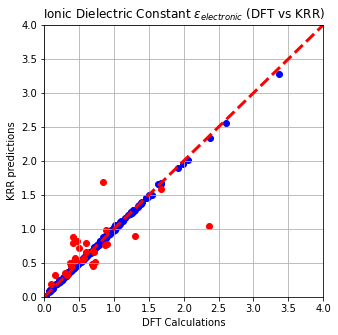

In [ ]:
plt.figure(figsize=(5,5))

plt.scatter(Y_ionic_train, Y_ionic_predicted_train,color='blue')
plt.scatter(Y_ionic_test,Y_ionic_predicted_test,color='red' )
xpoints = plt.xlim([0,4])
ypoints = plt.ylim([0,4])
plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=3, scalex=False, scaley=False)
plt.title(r'Ionic Dielectric Constant $\epsilon_{electronic}$ (DFT vs KRR)')
plt.grid()
plt.xlabel('DFT Calculations')
plt.ylabel('KRR predictions')